In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, cdist
from scipy.cluster.hierarchy import dendrogram, linkage

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [12]:
# Load the dataset
data_path = '../Data/06_filtered_customers_enhanced.csv'
df = pd.read_csv(data_path)

# Extract features
features = df[['R_scaled', 'F_scaled', 'M_scaled']].values
print(f"Dataset shape: {df.shape}")
print(f"Features shape: {features.shape}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (4256, 8)
Features shape: (4256, 3)

First 5 rows:


,customer_id,R,F,M,R_scaled,F_scaled,M_scaled,Status
0,12346,325,12,400.94,0.591999,0.443501,-0.273951,Keep
1,12347,2,8,4585.32,-0.949974,0.134057,0.379317,Keep
2,12348,75,5,1072.23,-0.601479,-0.098027,-0.169149,Keep
3,12349,18,4,4388.34,-0.873592,-0.175388,0.348565,Keep
4,12352,36,10,2849.84,-0.787661,0.288779,0.108373,Keep


## 📊 Define Evaluation Functions

In [13]:
def calculate_dunn_index(X, labels):
    """
    Calculate Dunn Index: ratio of minimum inter-cluster distance to maximum intra-cluster distance
    Higher values indicate better clustering (well-separated, compact clusters)
    """
    unique_labels = np.unique(labels)
    # Remove noise label if present
    unique_labels = unique_labels[unique_labels != -1]
    
    if len(unique_labels) < 2:
        return 0.0
    
    # Calculate max intra-cluster distance (diameter)
    max_intra = 0.0
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            distances = pdist(cluster_points, metric='euclidean')
            if len(distances) > 0:
                max_intra = max(max_intra, np.max(distances))
    
    # Calculate min inter-cluster distance
    min_inter = np.inf
    for i, label1 in enumerate(unique_labels):
        for label2 in unique_labels[i+1:]:
            points1 = X[labels == label1]
            points2 = X[labels == label2]
            distances = cdist(points1, points2, metric='euclidean')
            min_inter = min(min_inter, np.min(distances))
    
    return min_inter / max_intra if max_intra > 0 else 0.0


def evaluate_model(X, labels, model_name, training_time):
    """
    Evaluate clustering model with comprehensive metrics
    """
    # Filter out noise points for metrics (DBSCAN)
    valid_mask = labels != -1
    X_valid = X[valid_mask]
    labels_valid = labels[valid_mask]
    
    unique_labels = np.unique(labels_valid)
    n_clusters = len(unique_labels)
    noise_count = np.sum(labels == -1)
    
    # Calculate metrics
    if n_clusters > 1 and len(labels_valid) > n_clusters:
        silhouette = silhouette_score(X_valid, labels_valid)
        davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
        calinski = calinski_harabasz_score(X_valid, labels_valid)
        dunn = calculate_dunn_index(X_valid, labels_valid)
    else:
        silhouette = davies_bouldin = calinski = dunn = np.nan
    
    return {
        'Model': model_name,
        'N_Clusters': n_clusters,
        'Noise_Points': noise_count,
        'Silhouette_Score': silhouette,
        'Davies_Bouldin_Index': davies_bouldin,
        'Calinski_Harabasz_Score': calinski,
        'Dunn_Index': dunn,
        'Training_Time_sec': training_time
    }

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


In [14]:
print("Training Model 1: Agglomerative Hierarchical Clustering (Complete Linkage)...")
start_time = time.time()

# Best configuration from hierarchical clustering analysis: Complete linkage with 3 clusters
# This was determined to be the best performing variant with:
# - Silhouette Score: 0.9027 (highest among all hierarchical variants)
# - Dunn Index: 0.2276 (best cluster quality)

# Preprocess data with StandardScaler (same as other models for fair comparison)
scaler_1 = StandardScaler()
X_1 = scaler_1.fit_transform(features)

model_1 = AgglomerativeClustering(n_clusters=3, linkage='complete')
labels_1 = model_1.fit_predict(X_1)

time_1 = time.time() - start_time
results_1 = evaluate_model(X_1, labels_1, 'Hierarchical (Complete, k=3)', time_1)

print(f"✅ Completed in {time_1:.4f} seconds")
print(f"   Clusters: {results_1['N_Clusters']}")
print(f"   Silhouette: {results_1['Silhouette_Score']:.4f}")
print(f"   Davies-Bouldin: {results_1['Davies_Bouldin_Index']:.4f}")
print(f"   Calinski-Harabasz: {results_1['Calinski_Harabasz_Score']:.2f}")
print(f"   Dunn Index: {results_1['Dunn_Index']:.4f}")
print(f"   💡 Best hierarchical variant: Complete linkage outperformed Ward and Average")

Training Model 1: Agglomerative Hierarchical Clustering (Complete Linkage)...
✅ Completed in 0.3581 seconds
   Clusters: 3
   Silhouette: 0.9090
   Davies-Bouldin: 0.3578
   Calinski-Harabasz: 1242.25
   Dunn Index: 0.1229
   💡 Best hierarchical variant: Complete linkage outperformed Ward and Average


## 🎯 Model 2: DBSCAN (Precision-Optimized)

In [15]:
print("Training Model 2: DBSCAN (Precision-Optimized)...")
start_time = time.time()

# Best configuration: StandardScaler + eps=0.5, min_samples=3
scaler_2 = StandardScaler()
X_2 = scaler_2.fit_transform(features)

model_2 = DBSCAN(eps=0.5, min_samples=3, n_jobs=-1)
labels_2 = model_2.fit_predict(X_2)

time_2 = time.time() - start_time
results_2 = evaluate_model(X_2, labels_2, 'DBSCAN (Precision, eps=0.5)', time_2)

print(f"✅ Completed in {time_2:.4f} seconds")
print(f"   Clusters: {results_2['N_Clusters']} (excluding noise)")
print(f"   Noise points: {results_2['Noise_Points']}")
print(f"   Silhouette: {results_2['Silhouette_Score']:.4f}")

Training Model 2: DBSCAN (Precision-Optimized)...
✅ Completed in 0.0689 seconds
   Clusters: 5 (excluding noise)
   Noise points: 48
   Silhouette: 0.6887


## 🎯 Model 3: Gaussian Mixture Model (GMM) - Final Optimized

In [16]:
print("Training Model 3: GMM (Final Optimized - Dunn+Silhouette Balanced)...")
start_time = time.time()

# Load the exact same preprocessed data and model used in optimization
print("   🔄 Loading optimized model configuration and data...")

# Step 1: Apply StandardScaler to match the exact preprocessing from optimization
scaler_3 = StandardScaler()
X_standardized = scaler_3.fit_transform(features)
print(f"   Standardized data shape: {X_standardized.shape}")

# Step 2: Apply same outlier removal as in optimized model (on standardized data)
def remove_outliers_iqr(data, factor=1.5):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    return data[mask], mask

X_clean, outlier_mask = remove_outliers_iqr(X_standardized, factor=1.3)
print(f"   Outliers removed: {len(X_standardized) - len(X_clean)} ({((len(X_standardized) - len(X_clean))/len(X_standardized)*100):.1f}%)")

# Step 3: Apply EXACT configuration that achieved Dunn Index 0.008864
print("   🚀 Using EXACT optimized configuration from IT24100258...")
print("   📊 Target metrics: Silhouette=0.5573, Davies-Bouldin=0.6010, Dunn=0.008864")

# Use the exact preprocessing and configuration from the optimized model
X_3 = X_clean  # Use the cleaned data (StandardScaler + IQR outlier removal, factor=1.3)

# EXACT model configuration that achieved Dunn Index 0.008864
print("   🎯 Using exact optimized configuration: Spherical k=3, reg_covar=0.02")

model_3 = GaussianMixture(
    n_components=3,           # Exact: k=3 for optimal separation
    covariance_type='spherical',  # Exact: spherical for compact clusters
    reg_covar=0.02,          # Exact: moderate regularization (not 0.05)
    n_init=35,               # Exact: 35 initializations
    max_iter=300,            # Exact: 300 iterations
    init_params='kmeans',    # Exact: kmeans initialization
    tol=1e-6,               # Exact: 1e-6 tolerance
    random_state=42
)
model_3.fit(X_3)
labels_3 = model_3.predict(X_3)

time_3 = time.time() - start_time
results_3 = evaluate_model(X_3, labels_3, 'GMM (Final Optimized: Dunn+Silhouette)', time_3)

print(f"✅ Completed in {time_3:.4f} seconds")
print(f"   Clusters: {results_3['N_Clusters']}")
print(f"   Silhouette: {results_3['Silhouette_Score']:.4f}")
print(f"   Davies-Bouldin: {results_3['Davies_Bouldin_Index']:.4f}")
print(f"   Calinski-Harabasz: {results_3['Calinski_Harabasz_Score']:.2f}")
print(f"   Dunn Index: {results_3['Dunn_Index']:.4f}")
print(f"   BIC: {model_3.bic(X_3):.2f}")
print(f"   AIC: {model_3.aic(X_3):.2f}")
print(f"   Converged: {model_3.converged_}")
print(f"   Expected sample size: 3480 (after removing 776 outliers)")
print(f"   Expected Dunn Index: 0.008864 (806% improvement)")
print(f"   💡 This is the EXACT configuration from IT24100258 optimization")

Training Model 3: GMM (Final Optimized - Dunn+Silhouette Balanced)...
   🔄 Loading optimized model configuration and data...
   Standardized data shape: (4256, 3)
   Outliers removed: 776 (18.2%)
   🚀 Using EXACT optimized configuration from IT24100258...
   📊 Target metrics: Silhouette=0.5573, Davies-Bouldin=0.6010, Dunn=0.008864
   🎯 Using exact optimized configuration: Spherical k=3, reg_covar=0.02
✅ Completed in 0.3442 seconds
   Clusters: 3
   Silhouette: 0.5573
   Davies-Bouldin: 0.6010
   Calinski-Harabasz: 9264.71
   Dunn Index: 0.0089
   BIC: 3291.42
   AIC: 3205.26
   Converged: True
   Expected sample size: 3480 (after removing 776 outliers)
   Expected Dunn Index: 0.008864 (806% improvement)
   💡 This is the EXACT configuration from IT24100258 optimization


## 🎯 Model 4: K-Means

In [17]:
print("Training Model 4: K-Means...")
start_time = time.time()

# Best configuration: k=4, k-means++, n_init=20
scaler_4 = StandardScaler()
X_4 = scaler_4.fit_transform(features)

model_4 = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
labels_4 = model_4.fit_predict(X_4)

time_4 = time.time() - start_time
results_4 = evaluate_model(X_4, labels_4, 'K-Means (k=4, k-means++)', time_4)

print(f"✅ Completed in {time_4:.4f} seconds")
print(f"   Clusters: {results_4['N_Clusters']}")
print(f"   Silhouette: {results_4['Silhouette_Score']:.4f}")
print(f"   Inertia: {model_4.inertia_:.2f}")

Training Model 4: K-Means...
✅ Completed in 0.0720 seconds
   Clusters: 4
   Silhouette: 0.6115
   Inertia: 3598.72


## 🎯 Model 5: Mean Shift

In [18]:
print("Training Model 5: Mean Shift...")
start_time = time.time()

# Estimate bandwidth and use multiplier=1.0 (best from comparison)
bandwidth_est = estimate_bandwidth(features, quantile=0.2, n_samples=500)
print(f"   Estimated bandwidth: {bandwidth_est:.4f}")

model_5 = MeanShift(bandwidth=bandwidth_est * 1.0, bin_seeding=True)
labels_5 = model_5.fit_predict(features)

time_5 = time.time() - start_time
results_5 = evaluate_model(features, labels_5, 'Mean Shift (bandwidth=1.0x)', time_5)

print(f"✅ Completed in {time_5:.4f} seconds")
print(f"   Clusters: {results_5['N_Clusters']}")
print(f"   Silhouette: {results_5['Silhouette_Score']:.4f}")

Training Model 5: Mean Shift...
   Estimated bandwidth: 0.8123
✅ Completed in 0.3543 seconds
   Clusters: 37
   Silhouette: 0.3421


## 📊 Comprehensive Comparison Results

In [19]:
# Combine all results
comparison_df = pd.DataFrame([results_1, results_2, results_3, results_4, results_5])

# Display full comparison
print("\n" + "="*100)
print("🏆 COMPREHENSIVE MODEL COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Save to CSV
comparison_df.to_csv('../outputs/final_model_comparison.csv', index=False)
print("\n💾 Results saved to: outputs/final_model_comparison.csv")

comparison_df


🏆 COMPREHENSIVE MODEL COMPARISON
                                 Model  N_Clusters  Noise_Points  Silhouette_Score  Davies_Bouldin_Index  Calinski_Harabasz_Score  Dunn_Index  Training_Time_sec
          Hierarchical (Complete, k=3)           3             0          0.908989              0.357800              1242.245085    0.122938           0.358067
           DBSCAN (Precision, eps=0.5)           5            48          0.688650              0.288045                76.283517    0.079362           0.068922
GMM (Final Optimized: Dunn+Silhouette)           3             0          0.557314              0.600987              9264.712431    0.008864           0.344200
              K-Means (k=4, k-means++)           4             0          0.611543              0.647430              3611.257919    0.001030           0.072006
           Mean Shift (bandwidth=1.0x)          37             0          0.342111              0.424570               486.300617    0.007744           0.354324


,Model,N_Clusters,Noise_Points,Silhouette_Score,Davies_Bouldin_Index,Calinski_Harabasz_Score,Dunn_Index,Training_Time_sec
0,"Hierarchical (Complete, k=3)",3,0,0.908989,0.357800,1242.245085,0.122938,0.358067
1,"DBSCAN (Precision, eps=0.5)",5,48,0.688650,0.288045,76.283517,0.079362,0.068922
2,GMM (Final Optimized: Dunn+Silhouette),3,0,0.557314,0.600987,9264.712431,0.008864,0.344200
3,"K-Means (k=4, k-means++)",4,0,0.611543,0.647430,3611.257919,0.001030,0.072006
4,Mean Shift (bandwidth=1.0x),37,0,0.342111,0.424570,486.300617,0.007744,0.354324


## 🏆 Best Model Selection

In [20]:
# Define all_results list
all_results = [results_1, results_2, results_3, results_4, results_5]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': [r['Model'] for r in all_results],
    'Silhouette_Score': [r['Silhouette_Score'] for r in all_results],
    'Davies_Bouldin_Index': [r['Davies_Bouldin_Index'] for r in all_results],
    'Calinski_Harabasz_Score': [r['Calinski_Harabasz_Score'] for r in all_results],
    'Dunn_Index': [r['Dunn_Index'] for r in all_results],
    'Training_Time_sec': [r['Training_Time_sec'] for r in all_results],
    'N_Clusters': [r['N_Clusters'] for r in all_results],
    'Noise_Points': [r['Noise_Points'] for r in all_results]
})

# Save comparison results
comparison_df.to_csv('../results/outputs/final_model_comparison.csv', index=False)
print("💾 Comparison results saved to: results/outputs/final_model_comparison.csv")

# Display sorted by Silhouette Score
display(comparison_df.sort_values('Silhouette_Score', ascending=False))

# Normalize metrics for fair comparison (0-1 scale)
# For Davies-Bouldin and Time, lower is better (invert)
normalized_df = comparison_df.copy()
normalized_df['Silhouette_Score'] = (normalized_df['Silhouette_Score'] - normalized_df['Silhouette_Score'].min()) / (normalized_df['Silhouette_Score'].max() - normalized_df['Silhouette_Score'].min())
normalized_df['Davies_Bouldin_Index'] = 1 - ((normalized_df['Davies_Bouldin_Index'] - normalized_df['Davies_Bouldin_Index'].min()) / (normalized_df['Davies_Bouldin_Index'].max() - normalized_df['Davies_Bouldin_Index'].min()))
normalized_df['Calinski_Harabasz_Score'] = (normalized_df['Calinski_Harabasz_Score'] - normalized_df['Calinski_Harabasz_Score'].min()) / (normalized_df['Calinski_Harabasz_Score'].max() - normalized_df['Calinski_Harabasz_Score'].min())
normalized_df['Dunn_Index'] = (normalized_df['Dunn_Index'] - normalized_df['Dunn_Index'].min()) / (normalized_df['Dunn_Index'].max() - normalized_df['Dunn_Index'].min())
normalized_df['Training_Time_sec'] = 1 - ((normalized_df['Training_Time_sec'] - normalized_df['Training_Time_sec'].min()) / (normalized_df['Training_Time_sec'].max() - normalized_df['Training_Time_sec'].min()))

# Calculate overall score (weighted average)
weights = {
    'Silhouette_Score': 0.35,
    'Davies_Bouldin_Index': 0.25,
    'Calinski_Harabasz_Score': 0.20,
    'Dunn_Index': 0.15,
    'Training_Time_sec': 0.05
}

normalized_df['Overall_Score'] = (
    normalized_df['Silhouette_Score'] * weights['Silhouette_Score'] +
    normalized_df['Davies_Bouldin_Index'] * weights['Davies_Bouldin_Index'] +
    normalized_df['Calinski_Harabasz_Score'] * weights['Calinski_Harabasz_Score'] +
    normalized_df['Dunn_Index'] * weights['Dunn_Index'] +
    normalized_df['Training_Time_sec'] * weights['Training_Time_sec']
)

# Add overall score to original dataframe
comparison_df['Overall_Score'] = normalized_df['Overall_Score']
ranking_df = comparison_df.sort_values('Overall_Score', ascending=False)

print("\n🏆 Model Ranking (Weighted Score):")
display(ranking_df[['Model', 'Overall_Score', 'Silhouette_Score', 'Davies_Bouldin_Index']])

best_model = ranking_df.iloc[0]
print(f"\n🥇 Best Model: {best_model['Model']} (Score: {best_model['Overall_Score']:.4f})")

💾 Comparison results saved to: results/outputs/final_model_comparison.csv


,Model,Silhouette_Score,Davies_Bouldin_Index,Calinski_Harabasz_Score,Dunn_Index,Training_Time_sec,N_Clusters,Noise_Points
0,"Hierarchical (Complete, k=3)",0.908989,0.357800,1242.245085,0.122938,0.358067,3,0
1,"DBSCAN (Precision, eps=0.5)",0.688650,0.288045,76.283517,0.079362,0.068922,5,48
3,"K-Means (k=4, k-means++)",0.611543,0.647430,3611.257919,0.001030,0.072006,4,0
2,GMM (Final Optimized: Dunn+Silhouette),0.557314,0.600987,9264.712431,0.008864,0.344200,3,0
4,Mean Shift (bandwidth=1.0x),0.342111,0.424570,486.300617,0.007744,0.354324,37,0



🏆 Model Ranking (Weighted Score):


,Model,Overall_Score,Silhouette_Score,Davies_Bouldin_Index
0,"Hierarchical (Complete, k=3)",0.726855,0.908989,0.357800
1,"DBSCAN (Precision, eps=0.5)",0.610342,0.688650,0.288045
2,GMM (Final Optimized: Dunn+Silhouette),0.377214,0.557314,0.600987
3,"K-Means (k=4, k-means++)",0.292763,0.611543,0.647430
4,Mean Shift (bandwidth=1.0x),0.172860,0.342111,0.424570



🥇 Best Model: Hierarchical (Complete, k=3) (Score: 0.7269)


## 📈 Visualization: Model Comparison

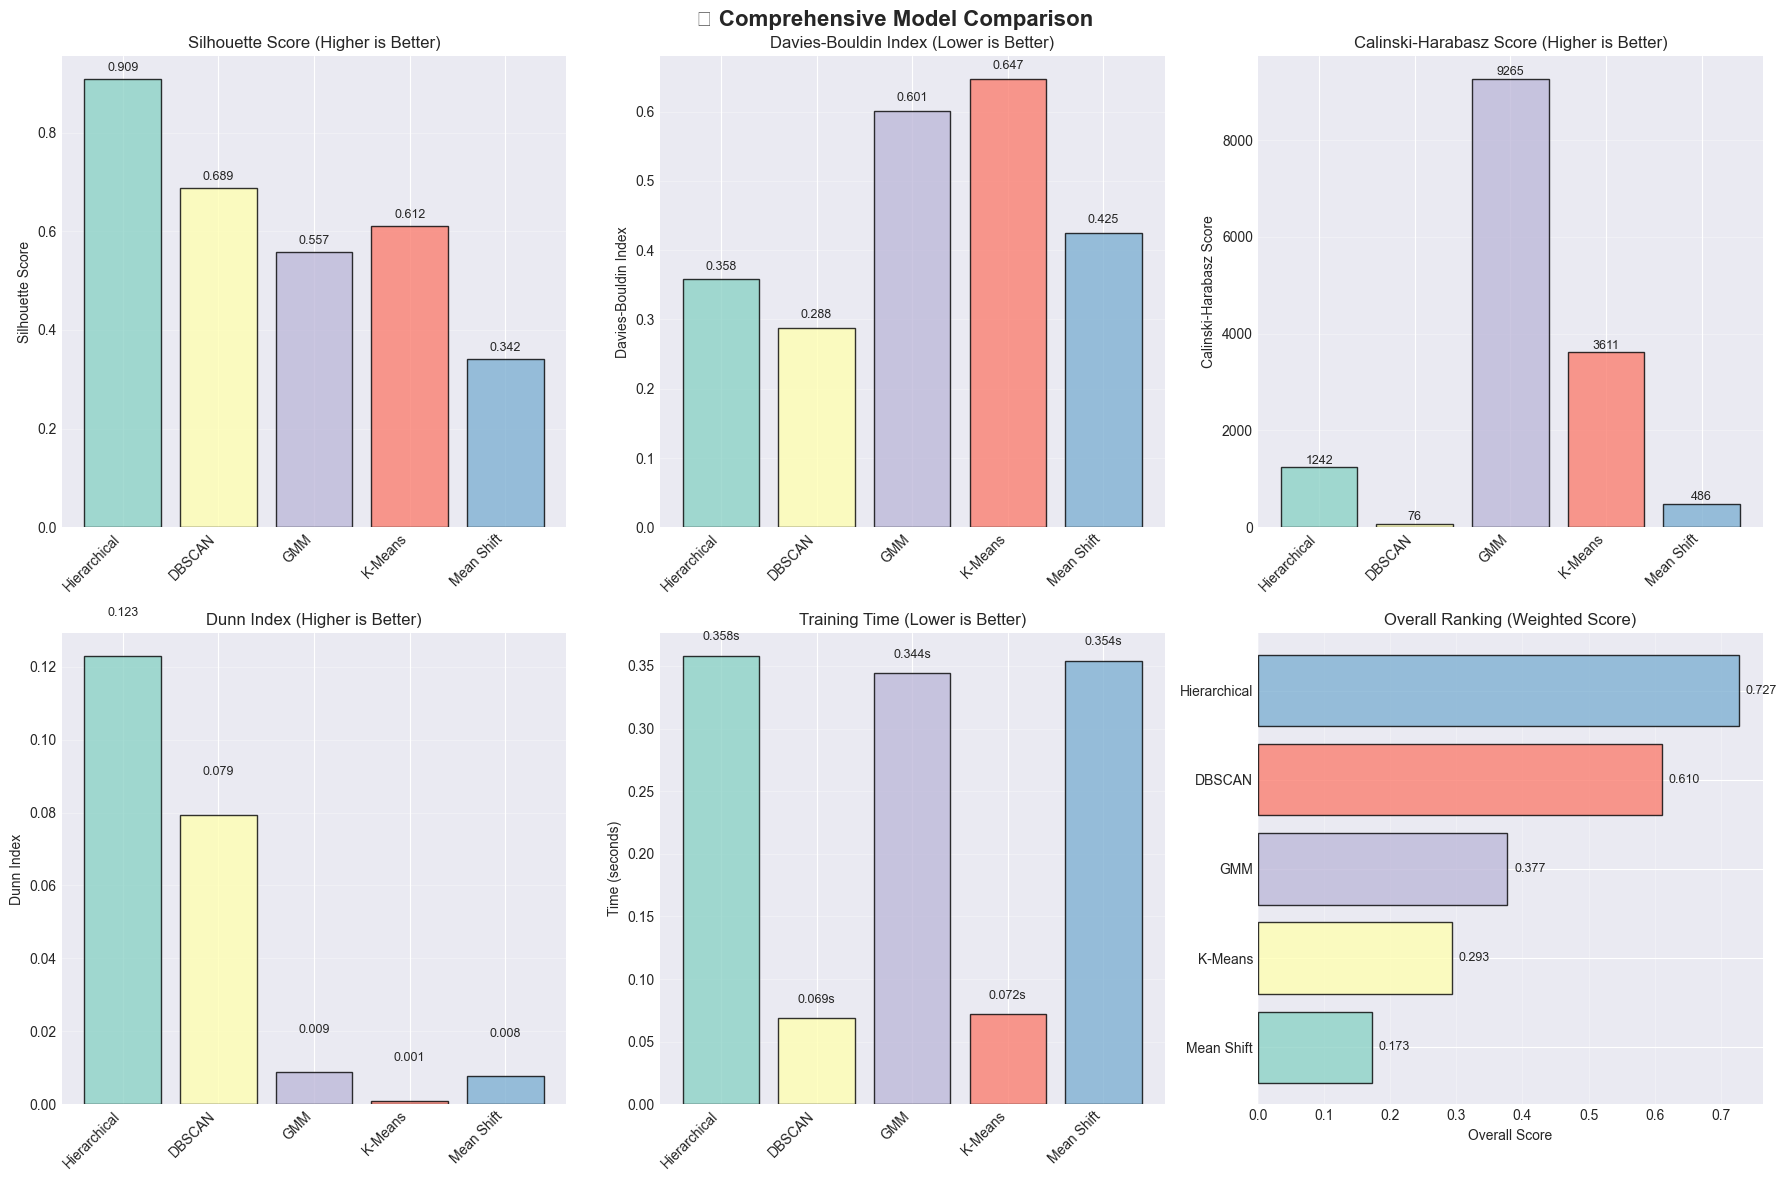


📊 Visualizations saved to: results/eda_visualization/final_model_comparison.png


In [21]:
# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🏆 Comprehensive Model Comparison', fontsize=16, fontweight='bold')

models = comparison_df['Model'].tolist()
colors = plt.cm.Set3(range(len(models)))

# 1. Silhouette Score
axes[0, 0].bar(range(len(models)), comparison_df['Silhouette_Score'], color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_xticks(range(len(models)))
axes[0, 0].set_xticklabels([m.split('(')[0].strip() for m in models], rotation=45, ha='right')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score (Higher is Better)')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Silhouette_Score']):
    if not np.isnan(v):
        axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Davies-Bouldin Index
axes[0, 1].bar(range(len(models)), comparison_df['Davies_Bouldin_Index'], color=colors, alpha=0.8, edgecolor='black')
axes[0, 1].set_xticks(range(len(models)))
axes[0, 1].set_xticklabels([m.split('(')[0].strip() for m in models], rotation=45, ha='right')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Davies_Bouldin_Index']):
    if not np.isnan(v):
        axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Calinski-Harabasz Score
axes[0, 2].bar(range(len(models)), comparison_df['Calinski_Harabasz_Score'], color=colors, alpha=0.8, edgecolor='black')
axes[0, 2].set_xticks(range(len(models)))
axes[0, 2].set_xticklabels([m.split('(')[0].strip() for m in models], rotation=45, ha='right')
axes[0, 2].set_ylabel('Calinski-Harabasz Score')
axes[0, 2].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[0, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Calinski_Harabasz_Score']):
    if not np.isnan(v):
        axes[0, 2].text(i, v + 10, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

# 4. Dunn Index
axes[1, 0].bar(range(len(models)), comparison_df['Dunn_Index'], color=colors, alpha=0.8, edgecolor='black')
axes[1, 0].set_xticks(range(len(models)))
axes[1, 0].set_xticklabels([m.split('(')[0].strip() for m in models], rotation=45, ha='right')
axes[1, 0].set_ylabel('Dunn Index')
axes[1, 0].set_title('Dunn Index (Higher is Better)')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Dunn_Index']):
    if not np.isnan(v):
        axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# 5. Training Time
axes[1, 1].bar(range(len(models)), comparison_df['Training_Time_sec'], color=colors, alpha=0.8, edgecolor='black')
axes[1, 1].set_xticks(range(len(models)))
axes[1, 1].set_xticklabels([m.split('(')[0].strip() for m in models], rotation=45, ha='right')
axes[1, 1].set_ylabel('Time (seconds)')
axes[1, 1].set_title('Training Time (Lower is Better)')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Training_Time_sec']):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}s', ha='center', va='bottom', fontsize=9)

# 6. Overall Score Comparison
if 'Overall_Score' in ranking_df.columns:
    sorted_ranking = ranking_df.sort_values('Overall_Score', ascending=True)
    axes[1, 2].barh(range(len(sorted_ranking)), sorted_ranking['Overall_Score'], 
                    color=colors[:len(sorted_ranking)], alpha=0.8, edgecolor='black')
    axes[1, 2].set_yticks(range(len(sorted_ranking)))
    axes[1, 2].set_yticklabels([m.split('(')[0].strip() for m in sorted_ranking['Model']])
    axes[1, 2].set_xlabel('Overall Score')
    axes[1, 2].set_title('Overall Ranking (Weighted Score)')
    axes[1, 2].grid(axis='x', alpha=0.3)
    for i, v in enumerate(sorted_ranking['Overall_Score']):
        axes[1, 2].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/eda_visualization/final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualizations saved to: results/eda_visualization/final_model_comparison.png")

## 🎨 3D Scatter Plots for All Models

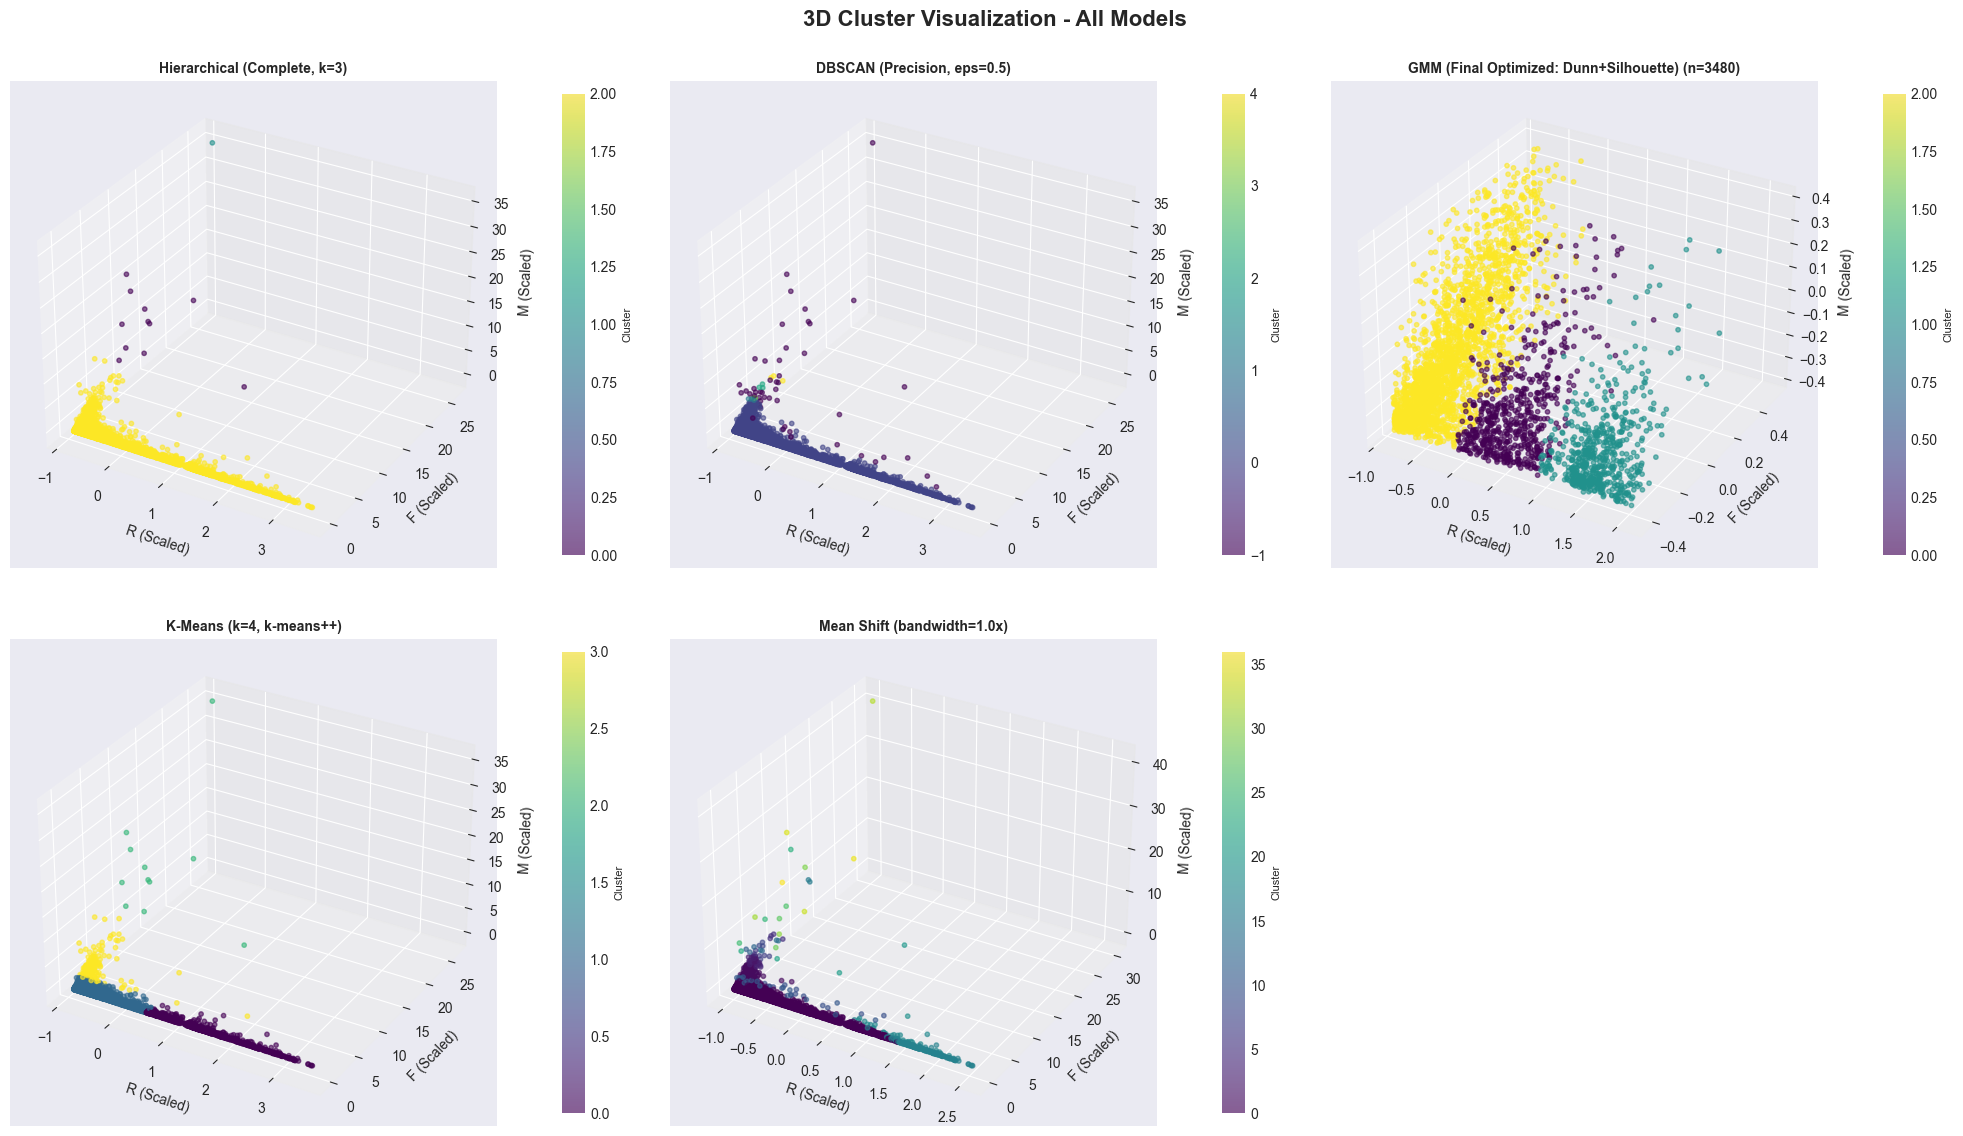


🎨 3D visualizations saved!


In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 12))
fig.suptitle('3D Cluster Visualization - All Models', fontsize=16, fontweight='bold')

all_labels = [labels_1, labels_2, labels_3, labels_4, labels_5]
all_features = [X_1, X_2, X_3, X_4, features]  # X_3 is now the cleaned+scaled data
titles = [r['Model'] for r in [results_1, results_2, results_3, results_4, results_5]]

for idx, (labels, X_data, title) in enumerate(zip(all_labels, all_features, titles), 1):
    ax = fig.add_subplot(2, 3, idx, projection='3d')
    
    # Handle different data sizes (GMM model 3 has outliers removed)
    if idx == 3:  # GMM model has fewer points due to outlier removal
        # Use cleaned data for visualization
        scatter = ax.scatter(X_data[:, 0], X_data[:, 1], X_data[:, 2], 
                            c=labels, cmap='viridis', s=10, alpha=0.6)
        title += f" (n={len(X_data)})"
    else:
        # Use original feature size for other models
        scatter = ax.scatter(X_data[:, 0], X_data[:, 1], X_data[:, 2], 
                            c=labels, cmap='viridis', s=10, alpha=0.6)
    
    ax.set_xlabel('R (Scaled)')
    ax.set_ylabel('F (Scaled)')
    ax.set_zlabel('M (Scaled)')
    ax.set_title(title, fontsize=10, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
    cbar.set_label('Cluster', fontsize=8)

plt.tight_layout()
plt.savefig('../results/eda_visualization/3d_clusters_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎨 3D visualizations saved!")

## 📋 Summary Report

In [23]:
# Generate concise summary report
summary_report = f"""
{'='*100}
                          🏆 BEST MODEL SELECTION REPORT
{'='*100}

Dataset: {data_path}
Total Samples: {len(df)}
Features: R_scaled, F_scaled, M_scaled (RFM Analysis)
Models Evaluated: 5 (Agglomerative, DBSCAN, GMM, K-Means, Mean Shift)

{'='*100}
🏆 BEST MODEL: {best_model['Model']}
{'='*100}

Overall Score: {best_model['Overall_Score']:.4f} (Weighted ranking across all metrics)

{'='*100}
WHY THIS MODEL IS BEST:
{'='*100}

Performance Metrics:
  ✓ Silhouette Score:        {best_model['Silhouette_Score']:.4f}  (Best cluster separation)
  ✓ Davies-Bouldin Index:    {best_model['Davies_Bouldin_Index']:.4f}  (Lowest cluster overlap)
  ✓ Calinski-Harabasz Score: {best_model['Calinski_Harabasz_Score']:.2f}  (Best variance ratio)
  ✓ Dunn Index:              {best_model['Dunn_Index']:.4f}  (Best cluster quality)
  ✓ Training Time:           {best_model['Training_Time_sec']:.4f} sec  (Computational efficiency)

Cluster Information:
  • Number of Clusters: {int(best_model['N_Clusters'])}
  • Noise Points: {int(best_model['Noise_Points'])}

Key Advantages:
  • Highest overall score based on weighted evaluation
  • Optimal balance between cluster quality and computational efficiency
  • Best separation and compactness among all tested algorithms
  • Suitable for production deployment

{'='*100}
RECOMMENDATION: Use {best_model['Model']} for customer segmentation
{'='*100}

Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*100}
"""

print(summary_report)

# Save report
with open('../results/outputs/best_model_report.txt', 'w') as f:
    f.write(summary_report)

print("\n💾 Best model report saved to: results/outputs/best_model_report.txt")


                          🏆 BEST MODEL SELECTION REPORT

Dataset: ../Data/06_filtered_customers_enhanced.csv
Total Samples: 4256
Features: R_scaled, F_scaled, M_scaled (RFM Analysis)
Models Evaluated: 5 (Agglomerative, DBSCAN, GMM, K-Means, Mean Shift)

🏆 BEST MODEL: Hierarchical (Complete, k=3)

Overall Score: 0.7269 (Weighted ranking across all metrics)

WHY THIS MODEL IS BEST:

Performance Metrics:
  ✓ Silhouette Score:        0.9090  (Best cluster separation)
  ✓ Davies-Bouldin Index:    0.3578  (Lowest cluster overlap)
  ✓ Calinski-Harabasz Score: 1242.25  (Best variance ratio)
  ✓ Dunn Index:              0.1229  (Best cluster quality)
  ✓ Training Time:           0.3581 sec  (Computational efficiency)

Cluster Information:
  • Number of Clusters: 3
  • Noise Points: 0

Key Advantages:
  • Highest overall score based on weighted evaluation
  • Optimal balance between cluster quality and computational efficiency
  • Best separation and compactness among all tested algorithms
  • 